In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
)
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

import sys
import os
import warnings


if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

In [11]:
path = "https://raw.githubusercontent.com/nogibjj/IDS705_FinalProject_Lemur_Team/main/01_clean_data/adult_ohe.csv"

adult_ohe = pd.read_csv(path)

X = adult_ohe.drop(columns=["income"])
y = adult_ohe["income"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [12]:
param_dist = {
    "criterion": ["gini", "entropy"],
    "max_depth": randint(1, 200),
    "min_samples_split": randint(2, 20),
    "min_samples_leaf": randint(1, 20),
    "max_features": randint(1, 105),
}

clf = DecisionTreeClassifier(random_state=42)

random_search = RandomizedSearchCV(
    clf,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring="accuracy",
    random_state=42,
)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_model = random_search.best_estimator_
best_params

{'criterion': 'entropy',
 'max_depth': 9,
 'max_features': 90,
 'min_samples_leaf': 2,
 'min_samples_split': 16}

In [13]:
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
auc_roc = roc_auc_score(y_test, y_pred_proba)
auc_pr = average_precision_score(y_test, y_pred_proba)


print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"AUC - ROC: {auc_roc:.3f}")
print(f"AUC - PR: {auc_pr:.3f}")

Accuracy: 0.858
Precision: 0.761
Recall: 0.597
F1 Score: 0.669
AUC - ROC: 0.905
AUC - PR: 0.770


In [15]:
# just do shap
import shap


def f(x):
    return best_model.predict_proba(x)[:, 1]


med = X_train.median().values.reshape((1, X_train.shape[1]))

explainer = shap.Explainer(f, med)
shap_values = explainer(X_test)

PermutationExplainer explainer: 9770it [00:21, 241.35it/s]                          


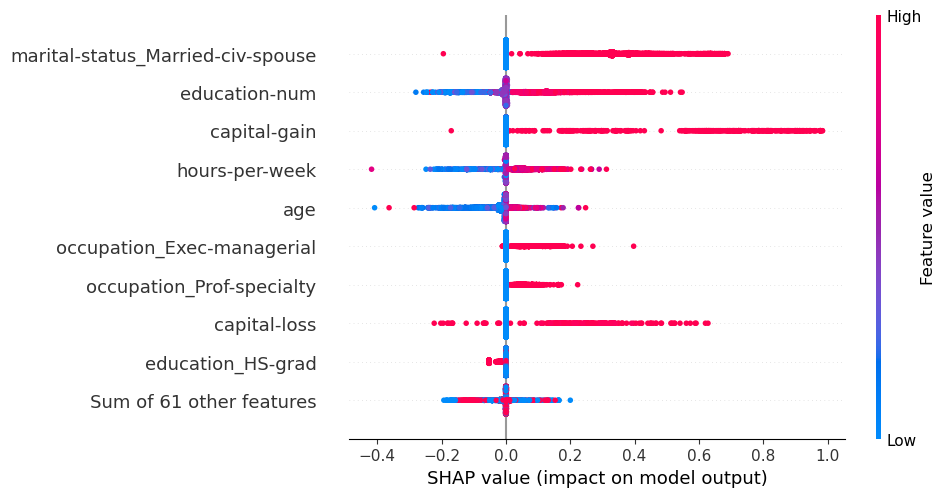

In [16]:
shap.plots.beeswarm(shap_values)

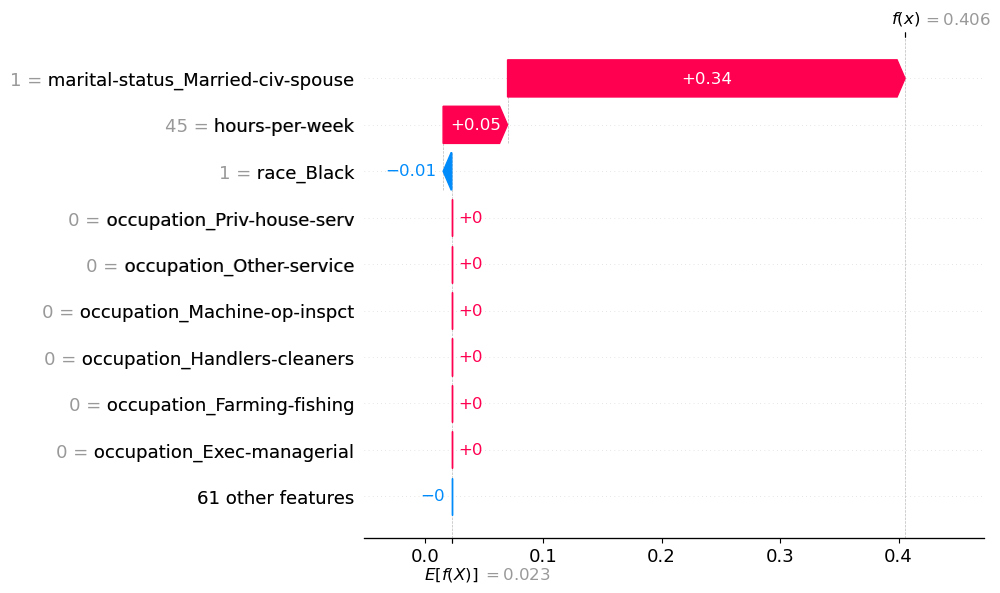

In [23]:
shap.plots.waterfall(shap_values[11])

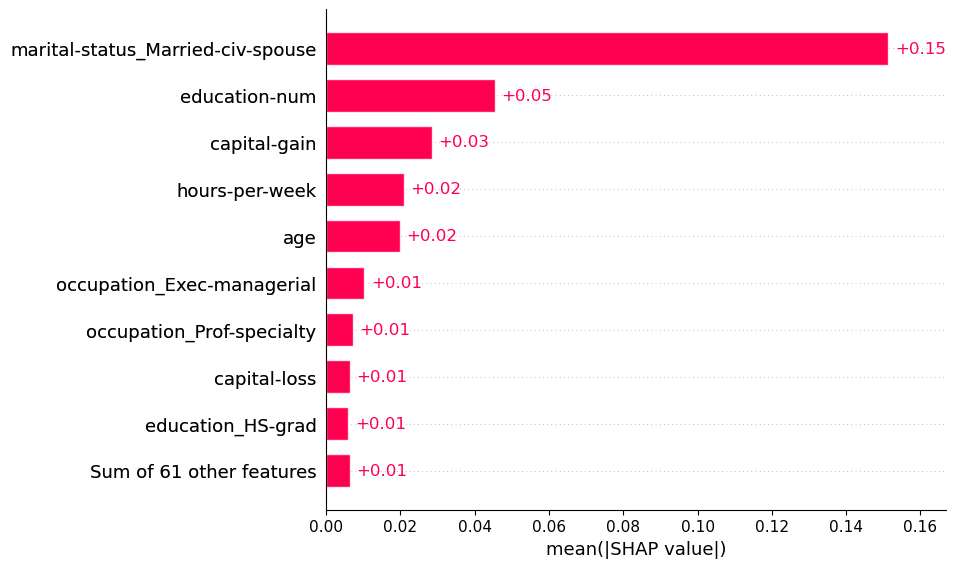

In [18]:
shap.plots.bar(shap_values)